<a href="https://colab.research.google.com/github/AliMostafaRadwan/BERT_for_QA/blob/main/Copy_of_main_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install session-info

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.3 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=7b1e8d6f181dd0e9974a6986aa88adb59a48f9674a0cd7ae35921550c0b09ee8
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [1]:
!pip install rouge

In [2]:
!pip install arabert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186458 sha256=79c5e2076656173eba03d3f1dab94ee8e42b1079449593f745e9f8a173d7a6e4
  Stored in directory: /root/.cache/pip/wheels/10/f0/fd/4813b1177405693e8da9cdea839f0fb64fde161380e058c827
Successfully built emoji


In [4]:
!pip install -U --no-cache-dir gdown --pre
# gdown --no-cookies XXX

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [ ]:
! gdown https://drive.google.com/u/0/uc?id=12Lqej0BcPelRQ81ewYrqkIl2xzfQald8&export=download

Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=12Lqej0BcPelRQ81ewYrqkIl2xzfQald8
From (redirected): https://drive.google.com/uc?id=12Lqej0BcPelRQ81ewYrqkIl2xzfQald8&confirm=t&uuid=270b801d-1da9-4855-9136-4b28910efda3
To: /content/ArabicMogalad_Ndeef.csv
100% 668M/668M [00:09<00:00, 68.1MB/s]


### Import libraries

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

In [ ]:
from pkl_to_df import load_WikiLingua


pd.set_option('display.max_rows', None)

data = load_WikiLingua("/content/drive/MyDrive/arabic.pkl")

data = pd.DataFrame(data["data"])

print(data.tail())


          idx                                           document  \
29193  9993_1  قد تصبح لديك مناطق من الماء الآسن إذا تشكلت كت...   
29194  9993_2  . يجب ألا تنمو الطحالب إذا بقيت مطلعًا على كيم...   
29195  9994_0  عند الانتهاء من تناول الوجبة وتدوين الملاحظات،...   
29196  9994_1  يجب أن تحصل على نفس التجربة التي سيحصل عليها أ...   
29197  9994_2  عندما يصل الطبق إلى طاولتك، دوّن ملاحظتك عن مظ...   

                                                 summary  
29193  قم بتحسين الدورة للتعامل مع مع البقع الصغيرة م...  
29194   حافظ على ماء حمام السباحة أضف مبيد الطحالب كو...  
29195  قم ببعض البحث. افتتح التقييم بجملة جذابة. صف 3...  
29196  تجنب إخبار العاملين بالمطعم أنك ناقد أو مقيّم ...  
29197  لاحظ طريقة تقديم الطبق. استمتع بأول قضمات. اكت...  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read Data

,Unnamed: 0,Text,Summary
0,0,تقدم لكم موقع الدستور الالكتروني بثا مباشرا ل...,بث مباشر بدون تقطيع لمباراه مانشستر يونايتد و...
1,1,بعثه المنتخب المغربي تحل ب مالابو بلاعبين فقط...,بعثه المنتخب المغربي تحل ب مالابو بلاعبين فقط...
2,2,رقم المشاركه تساعد الملوخيه علي تهدئه الاعصاب...,الملوخيه لذيذه وصحيه
3,3,شرح محمد ابراهيم مدرب عام فريق بتروجيت الوسيل...,مدرب بتروجيت يشرح لالدستور كيف حافظ فريقه علي...
4,4,و السؤال كيف يضع ابليس عرشه علي الماء شاهد ال...,هل تعلم اين يعيش ابليس و ما هي علاقته بمثلث ب...


### Preprocessing Data

In [ ]:
data = data[['document', 'summary']]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29198 entries, 0 to 29197
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   document  29198 non-null  object
 1   summary   29198 non-null  object
dtypes: object(2)
memory usage: 456.3+ KB


Removing rows with null

In [ ]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29198 entries, 0 to 29197
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   document  29198 non-null  object
 1   summary   29198 non-null  object
dtypes: object(2)
memory usage: 456.3+ KB


<ipython-input-12-9529224e9d0a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Removing duplicate rows

In [ ]:
sum(data.duplicated())

1

In [ ]:
data = data.drop_duplicates(subset=['document', 'summary'], keep='last')
sum(data.duplicated())

0

In [ ]:
data.shape

(29197, 2)

In [ ]:
df=data.copy()

In [ ]:
df = df.iloc[:29000,:]

In [ ]:
texts = df.document.values.tolist()
summaries = df.summary.values.tolist()

Letter normalization

In [ ]:
def normalize(text):
  text = re.sub("[إأآا]", "ا", text)
  text = re.sub("ى", "ي", text)
  text = re.sub("ؤ", "ء", text)
  text = re.sub("ئ", "ء", text)
  text = re.sub("ة", "ه", text)
  text = re.sub("گ", "ك", text)
  return text

In [ ]:
texts = [normalize(t) for t in texts]
summaries = [normalize(t) for t in summaries]

Removing stop words from data

In [6]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopwords_list = stopwords.words('arabic')

In [ ]:
# stopwords_list

In [ ]:
def remove_wstop(text):
  new_text = []
  for t in text.split():
    if t not in stopwords_list:
      new_text.append(t)

  return ' '.join(new_text)


In [ ]:
texts = [remove_wstop(t) for t in texts]
summaries = [remove_wstop(t) for t in summaries]

Removing any unwanted
characters

In [7]:
import re
def remove_char(text):
  text = re.sub('([@A-Za-z0-9_]+)|[^\w\s]|#|http\S+', '', text) # cleaning up
  return text

In [ ]:
texts = [remove_char(t) for t in texts]
summaries = [remove_char(t) for t in summaries]

In [ ]:
texts[0]

'يكون سعر الفاكهه والخضراوات موسم انباتها اقل غيره المواسم وستلجا محلات الخضروات الي عرض الفاكهه باسعار مناسبه موسمها بسبب توفر المنتجات وزياده الطلب عليها خلال الفترات يقتصر الامر علي السعر الاقل سيكون طعامك الخضراوات والفاكهه اشهي والذ تناوله موسمه فصل الخريف التفاح والتين والبنجر والكمثري والقرنبيط والكرنب واليقطين فصل الشتاء الخضراوات الملفوف والفاصوليا والبازلاء والبصل الفواكه البطاطا الحلوه والافوكادو والبرتقال والتفاح والموز واليوسفي والرمان والعنب فصل الربيع السبانخ والجزر والكوسه والبصل الاخضر والطماطم والخضراوات الورقيه والفراوله والمشمش فصل الصيف الصيف فصل البطيخ وكذلك الامر بالنسبه للذره والتوت تلاحظ توفر الخضراوات والفواكهه المهمه علي مدار العام كله بشكل او اخر ولكنها تكون بارخص اسعارها فصل الصيف يمكنك شراء كميات كبيره وتخزينها او تجميدها المجمد الفريزر الافضل لصحتك البدنيه والماليه علي حد سواء تناول الفواكه والخضراوات والاطعمه الطازجه عامه الحالات يكون الارخص بالنسبه الاعتماد علي الطعام المعبا تحصل علي الفواءد الغذاءيه بشرط التاكد انه مضاف اليه اي ملح او سكر او مواد مصنعه

Applying AraBERT Preprocess on data

In [ ]:
from arabert import ArabertPreprocessor
model_name = "aubmindlab/bert-base-arabertv2"
arabert_prep = ArabertPreprocessor(model_name=model_name)

texts = [arabert_prep.preprocess(t) for t in texts]
summaries = [arabert_prep.preprocess(t) for t in summaries]

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'farasa-api.qcri.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


100%|██████████| 241M/241M [00:22<00:00, 10.9MiB/s]


[2023-06-30 12:46:13,919 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [ ]:
# text = "ولن نبالغ إذا قلنا: إن 'هاتف' أو 'كمبيوتر المكتب' في زمننا هذا ضروري"
# text = arabert_prep.preprocess(text)
# text

In [ ]:
def remove_additions(text):
  # text = re.sub('[a-zA-Z]*\+[a-zA-Z]*', "", text) # cleaning up /\b\w*[Yy]\w*\b/g
  text = re.sub('\+\w+\s', '', text) # cleaning up
  text = re.sub('\w+\+\s', '', text) # cleaning up
  return text

In [ ]:
# text = remove_additions(text)
# text

In [ ]:
texts = [remove_additions(t) for t in texts]
summaries = [remove_additions(t) for t in summaries]

In [ ]:
texts[0]

'يكون سعر فاكهه خضراوات موسم انب أقل غير مواسم تلجا محل خضرو الي عرض فاكهه أسعار مناسب موسم سبب توفر منتج زياد طلب علي خلال فتر يقتصر أمر علي سعر أقل يكون طعام خضراوات فاكهه اشهي الذ تناول موسم فصل خريف تفاح تين بنجر كمثري قرنبيط كرنب يقطين فصل شتاء خضراوات ملفوف فاصوليا بازلاء بصل فواكه بطاطا حلوه افوكادو برتقال تفاح موز يوسفي رمان عنب فصل ربيع سبانخ جزر كوسه بصل أخضر طماطم خضراوات ورقيه فراوله مشمش فصل صيف صيف فصل بطيخ كذلك أمر نسبه ذره توت تلاحظ توفر خضراوات فواكهه مهمه علي مدار عام كل شكل أو آخر لكن تكون ارخص اسعار فصل صيف يمكن شراء كمي كبير تخزين أو تجميد مجمد فريزر أفضل صح بدنيه ماليه علي حد سواء تناول فواكه خضراوات اطعمه طازجه عام حال يكون ارخص نسبه اعتماد علي طعام معبا تحصل علي فواءد غذاءيه شرط تأكد مضاف إلي اي ملح أو سكر أو مواد مصنع اتبع نصيحه فواكه خضراوات كذلك مصادر بروتين يكون سعر فراخ مجمده مثل ارخص طازجه مثل حال عبو تونه سالم مقارن شراء سمك نوع طازج تحرص عديد محل اطعمه غذاءيه اختلاف انواع علي تقديم عروض خاص عملاء وتير اسبوعي يمكن اطلاع عبر مطبوع إعلان صفح رسميه عبر ساءل 

In [ ]:
data.iloc[0,0]

'يكون سعر الفاكهة والخضراوات في موسم إنباتها أقل من غيره من المواسم، وستلجأ محلات الخضروات إلى عرض الفاكهة بأسعار مناسبة في موسمها بسبب توفر المنتجات وزيادة الطلب عليها خلال تلك الفترات. لا يقتصر الأمر على السعر الأقل، بل سيكون طعامك من الخضراوات والفاكهة أشهى وألذ عند تناوله في موسمه.   في فصل الخريف: التفاح والتين والبنجر والكمثرى والقرنبيط والكرنب واليقطين في فصل الشتاء: (الخضراوات) الملفوف والفاصوليا والبازلاء والبصل (الفواكه)  البطاطا الحلوة والأفوكادو والبرتقال والتفاح والموز واليوسفى والرمان والعنب. في فصل الربيع: السبانخ والجزر والكوسة والبصل الأخضر  والطماطم والخضراوات الورقية والفراولة والمشمش. في فصل الصيف: الصيف هو فصل البطيخ، وكذلك الأمر بالنسبة للذرة والتوت. سوف تلاحظ توفر هذه الخضراوات والفواكهة المهمة على مدار العام كله بشكل أو آخر، ولكنها تكون بأرخص أسعارها في فصل الصيف، وهو ما يمكنك من شراء كميات كبيرة منها وتخزينها أو تجميدها في المُجمد (الفريزر). الأفضل لصحتك البدنية والمالية على حد سواء هو تناول الفواكه والخضراوات والأطعمة الطازجة عامة، ولكن في بعض الحالات قد يكون 

Determining the Maximum Permissible Sequence Lengths

In [ ]:
txt_len = [len(t.split()) for t in texts]
smy_len = [len(t.split()) for t in summaries]

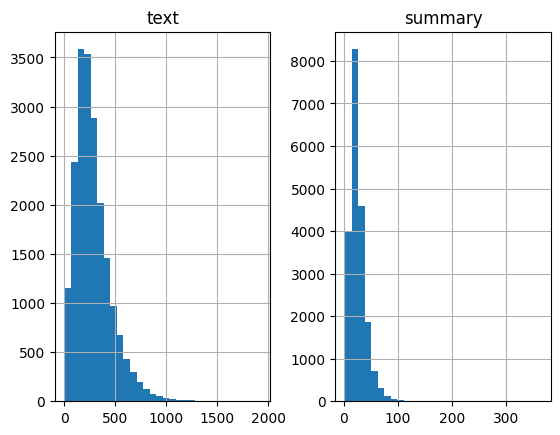

In [ ]:
import matplotlib.pyplot as plt
length_df = pd.DataFrame({'text':txt_len, 'summary':smy_len})
length_df.hist(bins = 30)
plt.show()

In [ ]:
max(txt_len), max(smy_len)

(1926, 364)

In [ ]:
max_text_len = 2000
max_summary_len = 30

Select the Summaries and Text which fall below max length

In [ ]:
import numpy as np

texts = np.array(texts)
summaries= np.array(summaries)

short_text = []
short_summary = []

for i in range(len(texts)):
    if len(summaries[i].split()) <= max_summary_len and len(texts[i].split()) <= max_text_len:
        short_text.append(texts[i])
        short_summary.append(summaries[i])

pre = pd.DataFrame({'text': short_text,'summary': short_summary})

pre.head(2)

,text,summary
0,اطعمه صحيه باهظ ثمن ضروره حقيق أمر تجد ان خيار...,فضل خيار اطعمه ارخص ثمن تباطا استهلاك بروتين ل...
1,استفد حديق منزليه أو اصيص زرع صغير شرفه انب خض...,ازرع يمكن خضراوات فاكه اط نفس جبا صغيره اط نفس...


In [ ]:
pre['summary'] = pre['summary'].apply(lambda x : 'start '+ x + ' end')

In [ ]:
for i in range(5):
    print("Text:",pre['text'][i])
    print("Summary:",pre['summary'][i])
    print("\n")

Text: اطعمه صحيه باهظ ثمن ضروره حقيق أمر تجد ان خيار اطعمه صحيه ارخص أغلب أحيان وجب صحي أحرص علي احتواء علي مواد غذاءيه يحتاج جسد مختلف تصنيف اطعمه أجل ضبط تكلف وجب اقتصادي اهدف اختيار طعام ارخص ثمن تصنيف طعام مختلفه تشكل جبا حديث حبوب كامله افضل علي مستوى صحي اقتصادي اطعم مثل شوف ارز بني برغل ذره مشويه مكرونه عيش اسمر اهدف شراء خضراوات ارخص سعر مثل جزر ملفوف خضر ورقيه مثل لفت قرنبيط شبت بقدونس شابه فضل تناول فاكهه ارخص سعر برتقال تفاح موز مثل التي تمنحك قيمه غذاءيه فاكهه باهظ سعر اختر أنواع فاكهه نوع ارخص سعر تفاح محلي خيار راءع ارخص سعر بدل تفاح مستورد حديث ألبان اشتر لبن محلي رخيص سعر كذلك زبادي عادي أحرص علي شراء حاوي كبير حصول علي سعر أفضل كيلو واحد فكر صنع زبادي باي طرق منزليه اختر منتج ألبان منكهه هي تكون ارخص سعر بينما يمكن تحلي نفس منزل نظير تكلف هين اهدف الي تقليل قدر إمكان كمي بروتين لحوم نظام غذاءي ذلك أغراض اقتصادي صحي علي حد سواء لحوم تقريب مكون اغلي ثمن وجب مثل فان تناول كثير دهون لحوم أكثر أخطاء تغذيه ضاره صحه نفترض مثل طبخ طبق فراخ عشاء يوم خطط تناول علي يوم ليس يوم وا

Tokenizing the Text

Split the data into train and test data parts.

In [ ]:
from sklearn.model_selection import train_test_split
X = pre["text"].values
y = pre["summary"].values

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.1,random_state=0)

Tokenize the text data and get vocabulary size

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(X))

# Prepare a tokenizer on testing data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y))

In [ ]:
thresh = 5

cnt = 0
tot_cnt = 0

for k, v in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if v < thresh:
        cnt = cnt + 1

print(f"TEXT: Prcentage of rare words in vocabulary: {(cnt / tot_cnt) * 100}")


thresh = 3

y_cnt = 0
y_tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    y_tot_cnt = y_tot_cnt + 1
    if value < thresh:
        y_cnt = y_cnt + 1

print("Summary: Prcentage of rare words in vocabulary:",(y_cnt / y_tot_cnt) * 100)

TEXT: Prcentage of rare words in vocabulary: 59.15587409363343
Summary: Prcentage of rare words in vocabulary: 48.061310644930835


In [ ]:
# Prepare a TEXT tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt)
x_tokenizer.fit_on_texts(list(X))

# Convert text sequences to integer sequences
x_tr_seq = x_tokenizer.texts_to_sequences(x_train)
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = len(x_tokenizer.word_index) + 1

print(f"Size of vocabulary in X = {x_voc}")

Size of vocabulary in X = 47719


In [ ]:
# Prepare a SUMMAARY tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=y_tot_cnt-y_cnt)
y_tokenizer.fit_on_texts(list(y))

# Convert text sequences to integer sequences
y_tr_seq = y_tokenizer.texts_to_sequences(y_train)
y_val_seq = y_tokenizer.texts_to_sequences(y_val)

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = len(y_tokenizer.word_index) + 1

print(f"Size of vocabulary in Y = {y_voc}")

Size of vocabulary in Y = 15398


skip_gram embedding

In [ ]:
corpus_X = [t.split() for t in X]
corpus_y = [t.split() for t in y]

In [ ]:
import gensim
dim = 150
window = 10
word2vec_x = gensim.models.Word2Vec(corpus_X, min_count=1, vector_size=dim, window=window, sg=1)

In [ ]:
dim = 150
window = 10
word2vec_y = gensim.models.Word2Vec(corpus_y, min_count=1, vector_size=dim,window=window, sg=1)

In [ ]:
# word2vec_x.wv.get_vector('مباراه')

In [ ]:
# load the whole embedding into memory
x_w2v_embeddings_index = {}
for word in word2vec_x.wv.index_to_key:
    x_w2v_embeddings_index[word] = word2vec_x.wv[word]
print('Loaded %s word vectors.' % len(x_w2v_embeddings_index))


Loaded 47734 word vectors.


In [ ]:
# create a weight matrix for words in training docs

x_embedding_matrix = np.zeros((x_voc, dim))
for word, i in x_tokenizer.word_index.items():
    # print(i, word)
    embedding_vector = x_w2v_embeddings_index.get(word)
    if embedding_vector is not None:
        x_embedding_matrix[i] = embedding_vector

print('Embedding Matrix shape:', x_embedding_matrix.shape)

Embedding Matrix shape: (47719, 150)


In [ ]:
# load the whole embedding into memory
y_w2v_embeddings_index = {}
for word in word2vec_y.wv.index_to_key:
    y_w2v_embeddings_index[word] = word2vec_y.wv[word]
print('Loaded %s word vectors.' % len(y_w2v_embeddings_index))


Loaded 15403 word vectors.


In [ ]:
# create a weight matrix for words in training docs
y_embedding_matrix = np.zeros((y_voc, dim))
for word, i in y_tokenizer.word_index.items():
    # print(i, word)
    embedding_vector = y_w2v_embeddings_index.get(word)
    if embedding_vector is not None:
        y_embedding_matrix[i] = embedding_vector

print('Embedding Matrix shape:', y_embedding_matrix.shape)

Embedding Matrix shape: (15398, 150)


### Define the encoder decoder model

###### 1. First we define Attension layer

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

# logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        # logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        # logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            # logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            # logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            # logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            # logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            # logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            # logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

###### 2. Define the model

In [ ]:

latent_dim = 300
embedding_dim=150
# Encoder
encoder_inputs = Input(shape=(max_text_len,), name='Encoder_Input')
#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim, weights=[x_embedding_matrix],
                      trainable=False, name='Encoder_Embedding')(encoder_inputs)
#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,
                      return_state=True,dropout=0.4,
                      name='Encoder_LSTM1')
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,
                      dropout=0.4, name='Encoder_LSTM2')
encoder_outputs, state_h, state_c = encoder_lstm2(encoder_output1)
#encoder lstm 3
# encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,
#                    dropout=0.4, name='Encoder_LSTM3')
# encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)


# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,), name='Decoder_Input')
#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, weights=[y_embedding_matrix],
                      trainable=False, name='Decoder_Embedding')
dec_emb = dec_emb_layer(decoder_inputs)
#decoder lstm
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,
                    dropout=0.4, name='Decoder_LSTM')
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])
# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


Training the Model

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

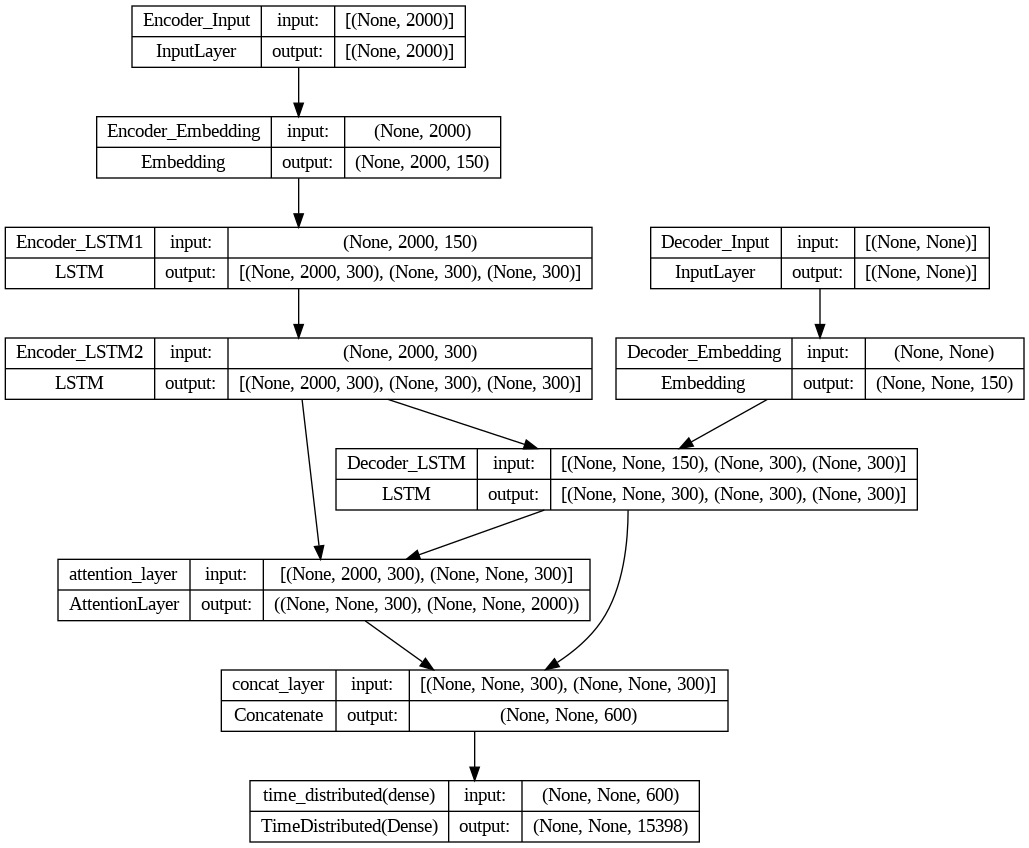

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# model.summary()

In [ ]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=50,
    callbacks=[es],
    batch_size=8,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/50
1608/1608 [==============================] - 557s 339ms/step - loss: 4.9257 - val_loss: 4.7137
Epoch 2/50
1608/1608 [==============================] - 543s 338ms/step - loss: 4.6101 - val_loss: 4.5544
Epoch 3/50
1608/1608 [==============================] - 561s 349ms/step - loss: 4.4784 - val_loss: 4.4776
Epoch 4/50
1608/1608 [==============================] - 544s 338ms/step - loss: 4.3879 - val_loss: 4.4258
Epoch 5/50
1608/1608 [==============================] - 542s 337ms/step - loss: 4.3187 - val_loss: 4.3908
Epoch 6/50
1608/1608 [==============================] - 542s 337ms/step - loss: 4.2607 - val_loss: 4.3617
Epoch 7/50
1608/1608 [==============================] - 562s 349ms/step - loss: 4.2089 - val_loss: 4.3377
Epoch 8/50
1608/1608 [==============================] - 542s 337ms/step - loss: 4.1622 - val_loss: 4.3229
Epoch 9/50
1608/1608 [==============================] - 541s 336ms/step - loss: 4.1190 - val_loss: 4.3016
Epoch 10/50
1608/1608 [=======================

Text(0.5, 1.0, 'Text Summarization \nTraining and Validation Loss Over Epochs')

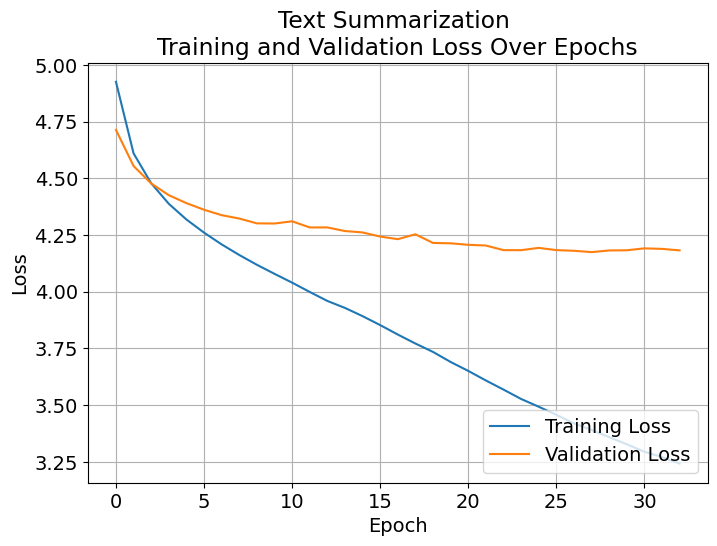

In [ ]:
#plot results
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 12))
plt.rcParams['figure.figsize'] = [16, 16]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Text Summarization \nTraining and Validation Loss Over Epochs')

#loss

Generating Predictions

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
reverse_source_word_index[0]='PAD'
reverse_target_word_index[0]='PAD'

In [ ]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c], verbose=0)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_summary_len-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    decoded_sentence = decoded_sentence.replace('PAD', '')
    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
pred_summaries = [decode_sequence(x.reshape(1,max_text_len)) for x in x_val]
true_summaries = [seq2summary(x) for x in y_val ]

1/1 [==============================] - 0s 93ms/step


In [ ]:
for i in range(0, 5):
    print ('Text:', seq2text(x_val[i]))
    print ('Original summary:', seq2summary(y_val[i]))
    print ('Predicted summary:', decode_sequence(x_val[i].reshape(1,max_text_len)))
    print()

In [ ]:
pred_summaries = [t.strip() for t in pred_summaries]
pred_summaries = [t for t in pred_summaries if t!="" or t!= " "]

In [ ]:
true_summaries = [t.strip() for t in true_summaries]
true_summaries = [t for t in true_summaries if t!="" or t!= " "]

In [ ]:
refs, hyps = [], []
for t1, t2 in zip(true_summaries, pred_summaries):
  if t1=="":
    pass
  elif t2=="":
    pass
  elif t2==" ":
    pass
  else:
    refs.append(t1)
    hyps.append(t2)

In [ ]:
from rouge import Rouge

rouge = Rouge()
scores = rouge.get_scores(hyps, refs, avg=True)
scores

{'rouge-1': {'r': 0.06437254934840296,
  'p': 0.24027425826206317,
  'f': 0.0963207116594932},
 'rouge-2': {'r': 0.007199649328252432,
  'p': 0.0167722521381058,
  'f': 0.009229688690146308},
 'rouge-l': {'r': 0.06403782309904257,
  'p': 0.23916561081195228,
  'f': 0.09581017485053456}}

In [8]:
import session_info
session_info.show()
